In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from pathlib import Path
import ontology.Schema as sc
import qai.QAI_Manager as q
import pickle
import os
from nlp.NLP_Processor import NLP_Processor
from classifier.ML_Classifier import ML_Classifier
from nlp.NER_Trainer import NER_Trainer 
from datetime import datetime
import spacy
import nlp.Solr_Connection as solr_connection
import pandas as pd

from config import *  #Change configurations in file "config.py"


%matplotlib inline


In [2]:
def train_QAIs():  
    schema = sc.getGraph(ontology_path)
    classes_index = sc.load_classes_index(schema)
    properties_index = sc.load_properties_index(schema)
    schema.close()
    QAI_Manager = q.QAI_Manager(QAIs_path,properties_index)
    ner_trainer = NER_Trainer(QAI_Manager.QAIs,classes_index,sparql_endpoint,graph_name,solr_host,solr_port,solr_core)
    ner_trainer.make_train_dataset(savePath=path_train_NER_temp)
    return QAI_Manager

In [3]:
def pre_process_classifier(QAI_Manager,use_semantic_features = True,number_qp_samples = 0):
    labels_path = os.path.join(path_train_NER_temp,"labels.sav")
    with open(labels_path,"rb") as file:
        labels_NER = pickle.load(file)
    nlp_processor = NLP_Processor(labels_NER,nlp_model_load,startup_solr=False)
    QAI_Manager.compute_SVs(nlp_processor)
    X,y = ML_Classifier.pre_process_data(QAI_Manager.QAIs,nlp_processor,use_semantic_features,number_qp_samples)
    return X,y


In [4]:
def train_classifier(X,y,model = None):
    classifier = ML_Classifier(model_path="persistence/classifier",model_file="ml_classifier.sav",model = model)
    time = classifier.fit(X,y)
    return classifier,time

# Experiments without Semantic Features (Only Syntatic Features)

In [5]:
QAIs_path = "input/medibot/MediBot.json"
QAI_Manager = train_QAIs()
X,y = pre_process_classifier(QAI_Manager,use_semantic_features = False,number_qp_samples = 0)


Creating train dataset
Created train dataset
Using semantic features False. QPs limited False


In [6]:
results = []

In [7]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.021782


Score evaluations using cross validation with cv = 5:
Precision = 0.7725
Recall = 0.7125
F-1 Score = 0.705952380952381


In [8]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.180394


Score evaluations using cross validation with cv = 5:
Precision = 0.6066666666666667
Recall = 0.6
F-1 Score = 0.5654761904761905


In [9]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',n_jobs=-1)

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:01.047190


Score evaluations using cross validation with cv = 5:
Precision = 0.8
Recall = 0.7875
F-1 Score = 0.7641666666666668


In [10]:
from sklearn.svm import SVC
model = SVC(gamma='auto')

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" auto",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.012123


Score evaluations using cross validation with cv = 5:
Precision = 0.5391666666666666
Recall = 0.575
F-1 Score = 0.5201190476190476


In [11]:
from sklearn.svm import SVC
model = SVC(C=1, kernel="linear")


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" linear",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.010613


Score evaluations using cross validation with cv = 5:
Precision = 0.9166666666666666
Recall = 0.875
F-1 Score = 0.8700000000000001


In [12]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=0)

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.014697


Score evaluations using cross validation with cv = 5:
Precision = 0.5458333333333333
Recall = 0.575
F-1 Score = 0.5341666666666666


In [13]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.025650


Score evaluations using cross validation with cv = 5:
Precision = 0.6791666666666666
Recall = 0.6
F-1 Score = 0.633452380952381


In [14]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
model = NearestCentroid()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.009076


Score evaluations using cross validation with cv = 5:
Precision = 0.63125
Recall = 0.625
F-1 Score = 0.5916666666666666


In [15]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" 1 layer",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.251051


Score evaluations using cross validation with cv = 5:
Precision = 0.9083333333333332
Recall = 0.9125
F-1 Score = 0.8683333333333334


In [16]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100,100))

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" 2 layers",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.178727


Score evaluations using cross validation with cv = 5:
Precision = 0.9416666666666667
Recall = 0.9125
F-1 Score = 0.9199999999999999


In [17]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.090363


Score evaluations using cross validation with cv = 5:
Precision = 0.17083333333333334
Recall = 0.275
F-1 Score = 0.19143790849673203


In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
model = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100),n_estimators=100,learning_rate=0.5)

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" (RandomForest)",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.095876


Score evaluations using cross validation with cv = 5:
Precision = 0.8458333333333332
Recall = 0.7125
F-1 Score = 0.7474999999999999


In [19]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.052627


Score evaluations using cross validation with cv = 5:
Precision = 0.44875
Recall = 0.475
F-1 Score = 0.41869047619047617


In [20]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append(['Nearest Neighbor',p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.006372


Score evaluations using cross validation with cv = 5:
Precision = 0.7079166666666666
Recall = 0.675
F-1 Score = 0.6576190476190475


In [21]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
model = QuadraticDiscriminantAnalysis()


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.152885


Score evaluations using cross validation with cv = 5:
Precision = 0.41380952380952374
Recall = 0.4375
F-1 Score = 0.3878968253968254


In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  VotingClassifier
gaussian = GaussianNB()
linear = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',n_jobs=-1)

model = VotingClassifier(estimators=[('gaus', gaussian), ('line', linear)],voting='soft',n_jobs=-1)


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append(["Soft "+type(clf.model).__name__+" (GaussianNB + LogisticRegression)",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.205546


Score evaluations using cross validation with cv = 5:
Precision = 0.7725
Recall = 0.7125
F-1 Score = 0.705952380952381


In [24]:
evaluations = pd.DataFrame(results,columns=['Classifier','Precision','Recall','F1','Time'])
top = evaluations.sort_values(['F1','Time'],ascending=[False,True])
top.to_csv("evaluations_syntatic.csv", encoding='utf-8', index=False)
top

,Classifier,Precision,Recall,F1,Time
9,MLPClassifier 2 layers,0.941667,0.9125,0.920000,00:00:00.178727
4,SVC linear,0.916667,0.8750,0.870000,00:00:00.010613
8,MLPClassifier 1 layer,0.908333,0.9125,0.868333,00:00:00.251051
2,LogisticRegression,0.800000,0.7875,0.764167,00:00:01.047190
11,AdaBoostClassifier (RandomForest),0.845833,0.7125,0.747500,00:00:00.095876
0,GaussianNB,0.772500,0.7125,0.705952,00:00:00.021782
15,Soft VotingClassifier (GaussianNB + LogisticRe...,0.772500,0.7125,0.705952,00:00:00.205546
13,Nearest Neighbor,0.707917,0.6750,0.657619,00:00:00.006372
6,RandomForestClassifier,0.679167,0.6000,0.633452,00:00:00.025650
7,NearestCentroid,0.631250,0.6250,0.591667,00:00:00.009076


# Experiments using Semantic Features

In [25]:
QAIs_path = "input/medibot/MediBot.json"
QAI_Manager = train_QAIs()
X,y = pre_process_classifier(QAI_Manager,use_semantic_features = True,number_qp_samples = 0)


Creating train dataset
Created train dataset
Using semantic features True. QPs limited False


In [26]:
results = []

In [27]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.003952


Score evaluations using cross validation with cv = 5:
Precision = 0.9833333333333332
Recall = 0.975
F-1 Score = 0.9733333333333334


In [28]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.004686


Score evaluations using cross validation with cv = 5:
Precision = 0.6641666666666666
Recall = 0.6875
F-1 Score = 0.6451190476190476


In [29]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',n_jobs=-1)

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.028661


Score evaluations using cross validation with cv = 5:
Precision = 0.9583333333333333
Recall = 0.9375
F-1 Score = 0.9333333333333333


In [30]:
from sklearn.svm import SVC
model = SVC(gamma='auto')

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" auto",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.007409


Score evaluations using cross validation with cv = 5:
Precision = 0.7491666666666666
Recall = 0.775
F-1 Score = 0.7319047619047618


In [31]:
from sklearn.svm import SVC
model = SVC(C=1, kernel="linear")


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" linear",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.006379


Score evaluations using cross validation with cv = 5:
Precision = 0.9833333333333332
Recall = 0.975
F-1 Score = 0.9733333333333334


In [32]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=0)

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.007405


Score evaluations using cross validation with cv = 5:
Precision = 0.8583333333333332
Recall = 0.875
F-1 Score = 0.8608333333333332


In [33]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.020386


Score evaluations using cross validation with cv = 5:
Precision = 0.6791666666666666
Recall = 0.65
F-1 Score = 0.8025


In [34]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
model = NearestCentroid()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.005260


Score evaluations using cross validation with cv = 5:
Precision = 0.8558333333333332
Recall = 0.8375
F-1 Score = 0.8226190476190476


In [35]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" 1 layer",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.165704


Score evaluations using cross validation with cv = 5:
Precision = 0.9625
Recall = 0.95
F-1 Score = 0.9466666666666667


In [36]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100,100))

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" 2 layers",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.176725


Score evaluations using cross validation with cv = 5:
Precision = 0.9833333333333332
Recall = 0.95
F-1 Score = 0.96


In [37]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.101881


Score evaluations using cross validation with cv = 5:
Precision = 0.2854166666666667
Recall = 0.475
F-1 Score = 0.3576190476190476


In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
model = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100),n_estimators=100,learning_rate=0.5)

clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__+" (RandomForest)",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.087451


Score evaluations using cross validation with cv = 5:
Precision = 0.8666666666666666
Recall = 0.875
F-1 Score = 0.8358333333333334


In [39]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.004891


Score evaluations using cross validation with cv = 5:
Precision = 0.7929166666666667
Recall = 0.775
F-1 Score = 0.7577380952380952


In [40]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append(['Nearest Neighbor',p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.004613


Score evaluations using cross validation with cv = 5:
Precision = 0.8791666666666667
Recall = 0.875
F-1 Score = 0.86


In [41]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
model = QuadraticDiscriminantAnalysis()


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append([type(clf.model).__name__,p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.006129


Score evaluations using cross validation with cv = 5:
Precision = 0.41380952380952374
Recall = 0.4375
F-1 Score = 0.3878968253968254


In [42]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  VotingClassifier
gaussian = GaussianNB()
linear = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',n_jobs=-1)

model = VotingClassifier(estimators=[('gaus', gaussian), ('line', linear)],voting='soft',n_jobs=-1)


clf,t = train_classifier(X,y,model = model)
p,r,f = clf.eval_model(X,y)
results.append(["Soft "+type(clf.model).__name__+" (GaussianNB + LogisticRegression)",p,r,f,t])

Using customized model
Training classifier done! Elapsed time: 0:00:00.112884


Score evaluations using cross validation with cv = 5:
Precision = 0.9833333333333332
Recall = 0.975
F-1 Score = 0.9733333333333334


In [43]:
evaluations = pd.DataFrame(results,columns=['Classifier','Precision','Recall','F1','Time'])
top = evaluations.sort_values(['F1','Time'],ascending=[False,True])
top.to_csv("evaluations_semantic.csv", encoding='utf-8', index=False)
top

,Classifier,Precision,Recall,F1,Time
0,GaussianNB,0.983333,0.9750,0.973333,00:00:00.003952
4,SVC linear,0.983333,0.9750,0.973333,00:00:00.006379
15,Soft VotingClassifier (GaussianNB + LogisticRe...,0.983333,0.9750,0.973333,00:00:00.112884
9,MLPClassifier 2 layers,0.983333,0.9500,0.960000,00:00:00.176725
8,MLPClassifier 1 layer,0.962500,0.9500,0.946667,00:00:00.165704
2,LogisticRegression,0.958333,0.9375,0.933333,00:00:00.028661
5,DecisionTreeClassifier,0.858333,0.8750,0.860833,00:00:00.007405
13,Nearest Neighbor,0.879167,0.8750,0.860000,00:00:00.004613
11,AdaBoostClassifier (RandomForest),0.866667,0.8750,0.835833,00:00:00.087451
7,NearestCentroid,0.855833,0.8375,0.822619,00:00:00.005260


# Evaluating the impact of the number of QPs in classification

## Using Semantic Features

In [59]:
results = []

In [60]:
from sklearn.naive_bayes import GaussianNB
for number_qps in range(2,11):
    model = GaussianNB()
    
    X,y = pre_process_classifier(QAI_Manager,use_semantic_features = True,number_qp_samples = number_qps)
    clf,t = train_classifier(X,y,model = model)
    cv=5
    if number_qps < 5:
        cv = max((number_qps - 1),2)
    p,r,f = clf.eval_model(X,y,cv=cv)
    results.append([number_qps,p,r,f,t])

Using semantic features True. QPs limited True
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Using customized model
Training classifier done! Elapsed time: 0:00:00.006387


Score evaluations using cross validation with cv = 2:
Precision = 0.47916666666666663
Recall = 0.625
F-1 Score = 0.5208333333333333
Using semantic features True. QPs limited True
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Using customized model
Training classifier done! Elapsed time: 0:00:00.006205


Score evaluations using cross validation with cv = 2:
Precision = 0.71875
Recall = 0.75
F-1 Score = 0.7166666666666667
Using semantic features True. QPs limited True
Reached QPs limited  4
Reached QPs limited  4
Reached QPs limited  4
Reached QPs

In [49]:
evaluations = pd.DataFrame(results,columns=['Number_QPs','Precision','Recall','F1','Time'])
top = evaluations.sort_values(['F1','Time'],ascending=[False,True])
top.to_csv("evaluations_semantic_number_qp.csv", encoding='utf-8', index=False)
top

,Number_QPs,Precision,Recall,F1,Time
8,10,0.983333,0.975000,0.973333,00:00:00.007401
6,8,0.920833,0.925000,0.915000,00:00:00.005539
7,9,0.900000,0.912500,0.893333,00:00:00.005716
5,7,0.850000,0.887500,0.862500,00:00:00.006161
3,5,0.820833,0.875000,0.837500,00:00:00.006661
4,6,0.793333,0.837500,0.801786,00:00:00.005310
2,4,0.708333,0.770833,0.725000,00:00:00.005207
1,3,0.718750,0.750000,0.716667,00:00:00.005655
0,2,0.479167,0.625000,0.520833,00:00:00.005247


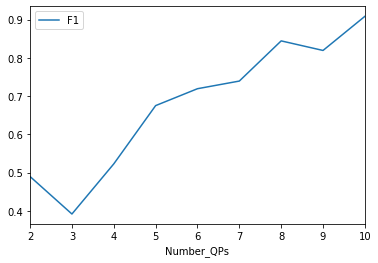

In [66]:
evaluations.plot.line(x='Number_QPs',y='F1')

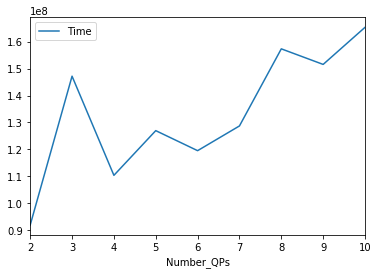

In [67]:
evaluations.plot.line(x='Number_QPs',y='Time')

## Without Semantic Features

In [61]:
results = []

In [62]:
from sklearn.neural_network import MLPClassifier
for number_qps in range(2,11):
    model = MLPClassifier(hidden_layer_sizes=(100,100))
    
    X,y = pre_process_classifier(QAI_Manager,use_semantic_features = False,number_qp_samples = number_qps)
    clf,t = train_classifier(X,y,model = model)
    cv=5
    if number_qps < 5:
        cv = max((number_qps - 1),2)
    p,r,f = clf.eval_model(X,y,cv=cv)
    results.append([number_qps,p,r,f,t])

Using semantic features False. QPs limited True
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Reached QPs limited  2
Using customized model
Training classifier done! Elapsed time: 0:00:00.091874


Score evaluations using cross validation with cv = 2:
Precision = 0.5520833333333333
Recall = 0.5
F-1 Score = 0.48958333333333326
Using semantic features False. QPs limited True
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Reached QPs limited  3
Using customized model
Training classifier done! Elapsed time: 0:00:00.147183


Score evaluations using cross validation with cv = 2:
Precision = 0.44791666666666663
Recall = 0.53125
F-1 Score = 0.39166666666666666
Using semantic features False. QPs limited True
Reached QPs limited  4
Reached QPs limited  4
Reached QPs limit

In [63]:
evaluations = pd.DataFrame(results,columns=['Number_QPs','Precision','Recall','F1','Time'])
top = evaluations.sort_values(['F1','Time'],ascending=[False,True])
top.to_csv("evaluations_syntatic_number_qp.csv", encoding='utf-8', index=False)
top

,Number_QPs,Precision,Recall,F1,Time
8,10,0.941667,0.900000,0.908333,00:00:00.165335
6,8,0.879167,0.887500,0.844167,00:00:00.157343
7,9,0.879167,0.900000,0.819167,00:00:00.151555
5,7,0.741667,0.787500,0.739167,00:00:00.128691
4,6,0.758333,0.775000,0.719167,00:00:00.119503
3,5,0.520833,0.675000,0.675000,00:00:00.126945
2,4,0.548611,0.604167,0.522685,00:00:00.110335
0,2,0.552083,0.500000,0.489583,00:00:00.091874
1,3,0.447917,0.531250,0.391667,00:00:00.147183


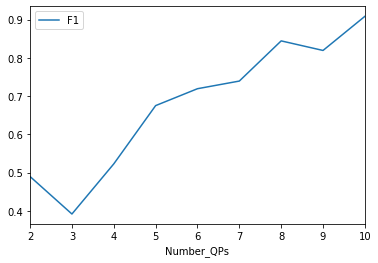

In [68]:
evaluations.plot.line(x='Number_QPs',y='F1')

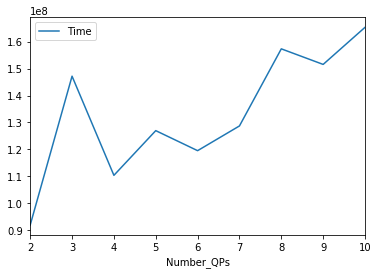

In [69]:
evaluations.plot.line(x='Number_QPs',y='Time')